In [ ]:
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,LabelEncoder,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import datetime
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import cv2
import os

In [ ]:
def preprocesa_atributos(input_path):
    
    HOY = pd.to_datetime(datetime.date(2021,6,30)) # Fecha nominal para calcular los días de cobertura pendiente
    '''
    Dada la ruta a un archivo devuelve partición en conjuntos de entrenamiento y validación
    input: ruta a un archivo, el que debe contener en una el link a la foto.
    output: Conjuntos de entrenamiento y Validación, además de pd.Series con ruta a las imágenes
    '''
    
    df=pd.read_csv(input_path, sep=';')
    df.dropna(inplace=True)
    df = df.drop(columns=['Condition']) # Queremos predecir el monto, por el momento no nos interesa
    df = df[(df['Amount']<=df['Cost_of_vehicle'])] #Filtramos casos: Monto del daño no debiera ser > valor auto
    df = df[df['Amount']>0] #Elimino vehículos sin daño
    
    df['Expiry_date']=pd.to_datetime(df['Expiry_date'])
    df['dias_pendientes_cobertura']=(df['Expiry_date']-HOY).dt.days.astype(int) #Permite contar días hasta fin cobertura
    df['relative_amount'] = df['Amount']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    df['relative_max_cov'] = df['Max_coverage']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    
    
    df = df.drop(columns=['Min_coverage','Expiry_date','Max_coverage','Amount'])
    
    scaler = MinMaxScaler() #Vamos a escalar variables numéricas
     
    X = df.drop(columns=['relative_amount'])
    y = df['relative_amount']
    
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=123)
    
    

    
    X_train_num = X_train[['Cost_of_vehicle','dias_pendientes_cobertura']]
    X_val_num = X_val[['Cost_of_vehicle','dias_pendientes_cobertura']]
    
    X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                      columns=X_train_num.columns,
                                      index=X_train.index)
    
    X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num), 
                                      columns=X_val_num.columns,
                                       index=X_val.index)
    
    lb = LabelBinarizer()# Codificaremos valores categóricos
    
    
    X_train_encoded = pd.DataFrame(lb.fit_transform(X_train['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_train.index)
    
    X_val_encoded = pd.DataFrame(lb.transform(X_val['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_val.index)
    
    
    X_train_feat = pd.concat([X_train['relative_max_cov'],X_train_num_scaled,X_train_encoded],axis=1)
    X_val_feat = pd.concat([X_val['relative_max_cov'],X_val_num_scaled,X_val_encoded],axis=1)
    
    X_train_im = X_train['Image_path']
    X_val_im = X_val['Image_path']
    
    
    return X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val

In [ ]:
X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val = preprocesa_atributos('/content/drive/MyDrive/train_original2.csv')

In [ ]:
Union_train = pd.concat([X_train_im, X_train_feat,y_train],axis=1)

x1=Union_train.copy()
x1['Image_path']=x1['Image_path'].str.replace('.jpg','_1.jpg')

x2=Union_train.copy()
x2['Image_path']=x2['Image_path'].str.replace('.jpg','_2.jpg')

x3=Union_train.copy()
x3['Image_path']=x3['Image_path'].str.replace('.jpg','_3.jpg')

x4=Union_train.copy()
x4['Image_path']=x4['Image_path'].str.replace('.jpg','_4.jpg')

x5=Union_train.copy()
x5['Image_path']=x5['Image_path'].str.replace('.jpg','_5.jpg')

Union_X_train = pd.concat([Union_train,x1,x2,x3,x4,x5], axis=0)

X_train_im = Union_X_train['Image_path']
X_train_feat = Union_X_train[['relative_max_cov','Cost_of_vehicle','dias_pendientes_cobertura','A','AA','AC','B','BB','BC','BQ','C','DA','O','RE']]
y_train = Union_X_train['relative_amount']



In [ ]:
def carga_imagenes(serie_fotos, inputPath):
    
    nuevas_imagenes = []
    for foto in serie_fotos:
        imagen = cv2.imread(inputPath+'/'+foto)
        imagen = cv2.resize(imagen, (64, 64)) #Dejo todas las fotos en 64 x 64
        nuevas_imagenes.append(imagen)
    return np.array(nuevas_imagenes)/255.0 # Normalizo a factor de 1

In [ ]:
def create_mlp(dim, regress=True):
    # Perceptron multicapas muy simple para Redes neuronales
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(1, activation="relu"))

    # ¿Hay nodo de regresión?
    if regress:
        model.add(Dense(1, activation="linear"))

    # Devuelve un modelo
    return model

In [ ]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
# Ojo: hay que cambiar orden de las dimensiones

    inputShape = (height, width, depth)
    chanDim = -1

    # Definir input del modelos
    inputs = Input(shape=inputShape)

    # Loop para cada uno de los filtros
    for (i, f) in enumerate(filters):
    # Ojo con capas de convolución
        if i == 0:
            x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Aplanar nuevamente, luego FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Dense(8)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # Aplicar al final
    x = Dense(1)(x)
    x = Activation("relu")(x)

    # ¿Hay nodo de regresión?
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [ ]:
imagenes_train = carga_imagenes(X_train_im,'/content/drive/MyDrive/Fotos_train_aum')
imagenes_val = carga_imagenes(X_val_im,'/content/drive/MyDrive/Fotos_train_aum')

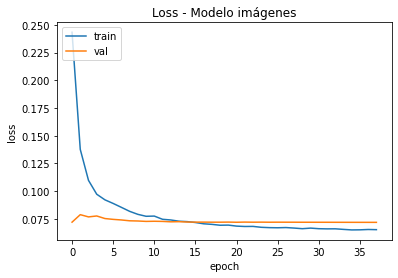

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


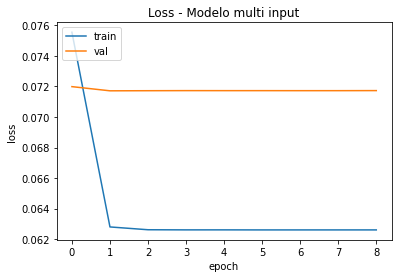

El error absoluto promedio del modelo que solo usa imágenes es 0.0719.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 1 finalizada


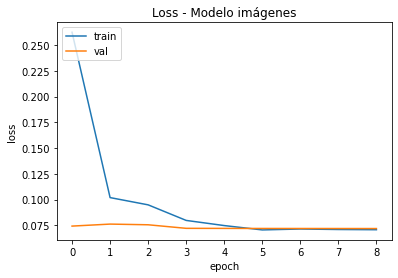

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


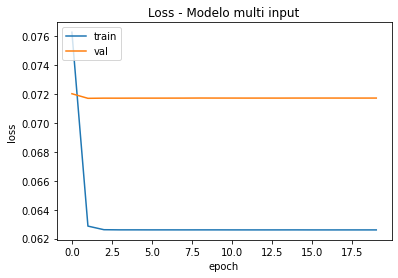

El error absoluto promedio del modelo que solo usa imágenes es 0.0718.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 2 finalizada


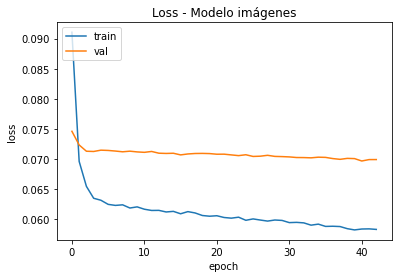

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


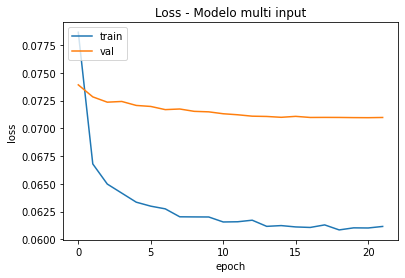

El error absoluto promedio del modelo que solo usa imágenes es 0.0699.
    A su vez, el error absoluto promedio del modelo multi input es 0.071.
Iteración 3 finalizada


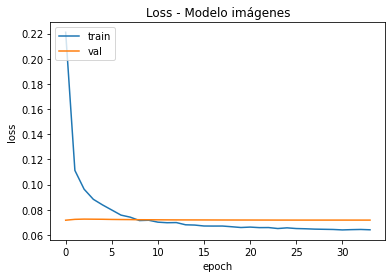

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


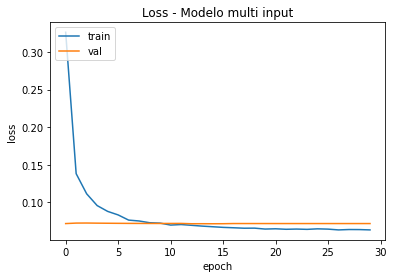

El error absoluto promedio del modelo que solo usa imágenes es 0.0718.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 4 finalizada


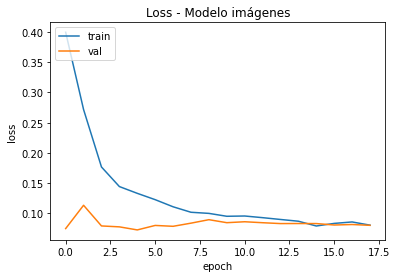

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


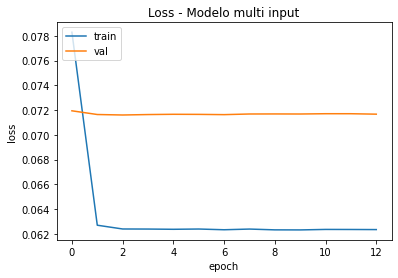

El error absoluto promedio del modelo que solo usa imágenes es 0.0803.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 5 finalizada


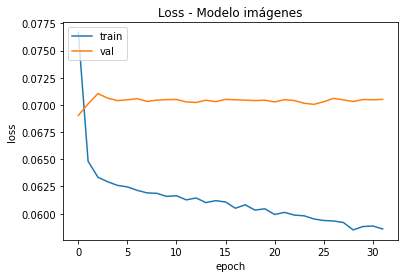

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


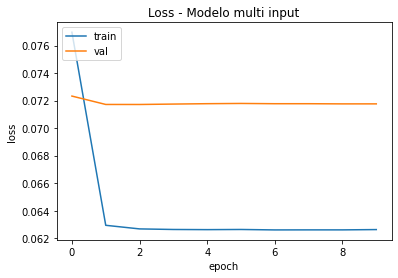

El error absoluto promedio del modelo que solo usa imágenes es 0.0705.
    A su vez, el error absoluto promedio del modelo multi input es 0.0718.
Iteración 6 finalizada


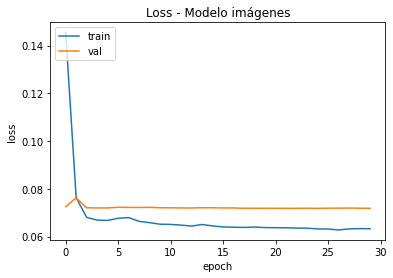

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


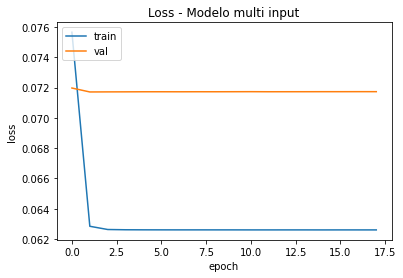

El error absoluto promedio del modelo que solo usa imágenes es 0.0718.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 7 finalizada


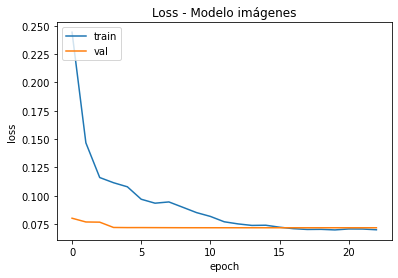

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


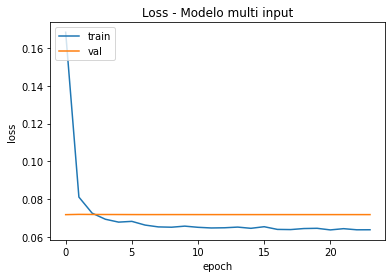

El error absoluto promedio del modelo que solo usa imágenes es 0.0717.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 8 finalizada


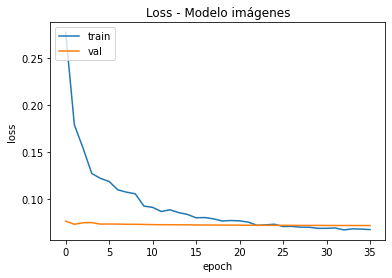

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


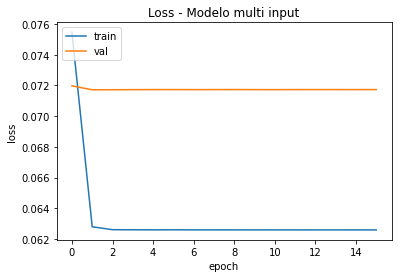

El error absoluto promedio del modelo que solo usa imágenes es 0.072.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 9 finalizada


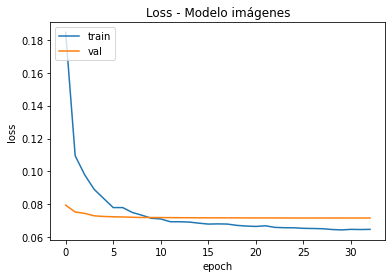

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


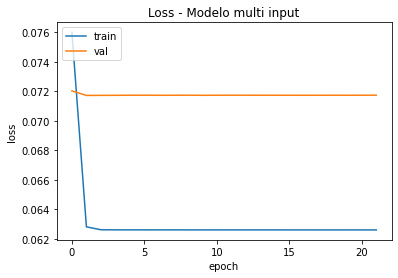

El error absoluto promedio del modelo que solo usa imágenes es 0.0717.
    A su vez, el error absoluto promedio del modelo multi input es 0.0717.
Iteración 10 finalizada


In [ ]:
resultados_modelo_solo_imagenes = []
resultados_modelo_multi_input = []

for i in range(10): #Voy a correr 10 veces el experimento
    
    cnn1 = create_cnn(64, 64, 3)
    cnn2 = create_cnn(64, 64, 3)
    mlp = create_mlp(X_train_feat.shape[1])

    opt = Adam(learning_rate=1e-3,decay = 1e-2) # Hiperparametros
    callback = EarlyStopping(monitor='loss', patience=3) # No quiero gastar recursos innecesarios, con callback

    cnn1.compile(loss="mae", 
                  optimizer=opt)

    #print("[INFO] Entrenando modelo con imágenes...")
    history_imagenes = cnn1.fit(
        x=imagenes_train, 
        y=y_train.values,
        validation_data=(imagenes_val, y_val.values),
        epochs=500, 
        batch_size=16,
        verbose=0,
        callbacks = [callback])

    # Listar la historia
    #print(history_imagenes.history.keys())
    # Generar gráficos
    plt.plot(history_imagenes.history['loss'])
    plt.plot(history_imagenes.history['val_loss'])
    plt.title('Loss - Modelo imágenes')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    y_pred_img = cnn1.predict(imagenes_val)

    error_promedio_imagenes = mean_absolute_error(y_val.values.flatten(),y_pred_img)
    
    resultados_modelo_solo_imagenes.append(error_promedio_imagenes)

    #Y ahora entreno el modelo que utiliza como insumos datos tabulares y las fotos

    combinedInput = concatenate([mlp.output, cnn2.output])
    x = Dense(1, activation="relu")(combinedInput)
    x = Dense(1, activation="linear")(x)

    model = Model(inputs=[mlp.input, cnn2.input], outputs=x)

    opt = Adam(lr=1e-3,decay = 1e-2) # Hiperparametros
    callback = EarlyStopping(monitor='loss', patience=3) # No quiero gastar recursos innecesarios, con callback

    model.compile(loss="mae", 
                  optimizer=opt)

    # Entrenamos el modelo
    #print("[INFO] Entrenando modelo multi input...")
    history = model.fit(
        x=[X_train_feat.values, imagenes_train], 
        y=y_train.values,
        validation_data=([X_val_feat.values, imagenes_val], y_val.values),
        epochs=100, 
        batch_size=16,
        verbose=0,
        callbacks = [callback])


    # Listar la historia
    #print(history.history.keys())
    # Generar gráficos
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss - Modelo multi input')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
    y_pred_mi = model.predict([X_val_feat.values, imagenes_val])

    error_promedio_mi = mean_absolute_error(y_val.values.flatten(),y_pred_mi)
    
    resultados_modelo_multi_input.append(error_promedio_mi)

    print(f"El error absoluto promedio del modelo que solo usa imágenes es {round(error_promedio_imagenes,4)}.\n\
    A su vez, el error absoluto promedio del modelo multi input es {round(error_promedio_mi,4)}." )
    print(f"Iteración {i+1} finalizada")
    
    del cnn1
    del cnn2
    del mlp

In [ ]:
imagenes_media = np.mean(resultados_modelo_solo_imagenes)
multi_input_media = np.mean(resultados_modelo_multi_input)

print("Promedio error solo imágenes:",imagenes_media)
print("Promedio error multi input:",multi_input_media)


imagenes_std = np.std(resultados_modelo_solo_imagenes)
multi_input_std = np.std(resultados_modelo_multi_input)

print("Desviación Estándar solo imágenes:",imagenes_std )
print("Desviación Estándar solo multi_input:",multi_input_std)

ttest,pval = ttest_ind(resultados_modelo_solo_imagenes,resultados_modelo_multi_input)

print("p-value",pval)
if pval <0.05:
  print("No aceptamos hipótesis nula, las medias debieran ser distintas")
else:
  print("Aceptamos la hipótesis nula, las medias deben ser equivalentes")

Promedio error solo imágenes: 0.0723573883354867
Promedio error multi input: 0.0716527210651455
Desviación Estándar solo imágenes: 0.0027388827177728804
Desviación Estándar solo multi_input: 0.00022658020326436288
p-value 0.4517388024190153
Aceptamos la hipótesis nula, las medias deben ser equivalentes


In [ ]:
compara = pd.DataFrame(zip(resultados_modelo_multi_input,resultados_modelo_solo_imagenes),
      columns=['error_solo_imagen','error_multi_input'])

In [ ]:
import seaborn as sns

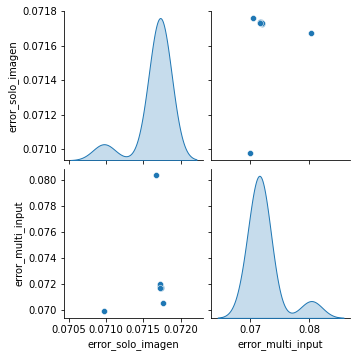

In [ ]:
sns.pairplot(compara, diag_kind='kde')

In [ ]:
compara.to_csv('resultados.csv',index=False)